In [37]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){return false;}

<IPython.core.display.Javascript object>

### Import libraries

In [38]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime

### Load the JSON data

In [39]:
with open('logins.json') as log:
    logins = json.load(log)

### Explore Data

In [40]:
print(logins.keys())
print(len(logins['login_time']))

dict_keys(['login_time'])
93142


In [41]:
login_df = pd.DataFrame(logins)
print(login_df.head(10))
print('\n')
print(login_df.describe())
print('\n')
print(login_df.info())
print('\n')
print(type(login_df.login_time[0]))

            login_time
0  1970-01-01 20:13:18
1  1970-01-01 20:16:10
2  1970-01-01 20:16:37
3  1970-01-01 20:16:36
4  1970-01-01 20:26:21
5  1970-01-01 20:21:41
6  1970-01-01 20:12:16
7  1970-01-01 20:35:47
8  1970-01-01 20:35:38
9  1970-01-01 20:47:52


                 login_time
count                 93142
unique                92265
top     1970-03-17 01:01:39
freq                      3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null object
dtypes: object(1)
memory usage: 727.8+ KB
None


<class 'str'>


### 93142 timestamp entries with 92265 of them being unique. The data is of type "string" and needs to be converted to timestamp

In [42]:
login_df.login_time = login_df.login_time.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
print(type(login_df.login_time[0]))

<class 'pandas._libs.tslib.Timestamp'>


### EDA  

#### Rules to pass into .resample() method for up/down sampling time series
*_________________________________________________________________*

* B       business day frequency
* C       custom business day frequency (experimental)
* D       calendar day frequency
* W       weekly frequency
* M       month end frequency
* SM      semi-month end frequency (15th and end of month)
* BM      business month end frequency
* CBM     custom business month end frequency
* MS      month start frequency
* SMS     semi-month start frequency (1st and 15th)
* BMS     business month start frequency
* CBMS    custom business month start frequency
* Q       quarter end frequency
* BQ      business quarter endfrequency
* QS      quarter start frequency
* BQS     business quarter start frequency
* A       year end frequency
* BA      business year end frequency
* AS      year start frequency
* BAS     business year start frequency
* BH      business hour frequency
* H       hourly frequency
* T       minutely frequency
* S       secondly frequency
* L       milliseonds
* U       microseconds
* N       nanoseconds

### Create a series of the timestamps while utilizing the timestamps as type "DateTimeIndex" for resampling

In [43]:
login_data = pd.Series(range(len(login_df)), index = login_df.login_time)

### Resample the data into 15 minute bins

In [44]:
fifteen_min_data = login_data.resample('15T').count()
print('First timestamp in the data: {}'.format(fifteen_min_data.index.min()))
print('Last timestamp in the data: {}'.format(fifteen_min_data.index.max()))
fifteen_min_data.head(10)

First timestamp in the data: 1970-01-01 20:00:00
Last timestamp in the data: 1970-04-13 18:45:00


login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
1970-01-01 21:15:00    4
1970-01-01 21:30:00    0
1970-01-01 21:45:00    4
1970-01-01 22:00:00    9
1970-01-01 22:15:00    8
Freq: 15T, dtype: int64

### It appears that the data runs from January 1st, 1970 to April 13th, 1970. Let's first take a look at the weekly logins for January alone to see if there's an immediate trends that stand out

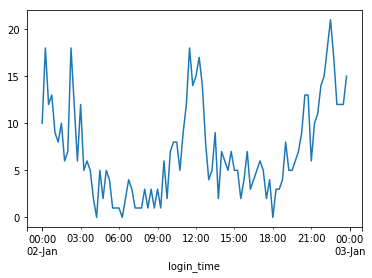

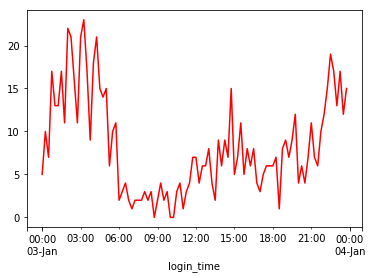

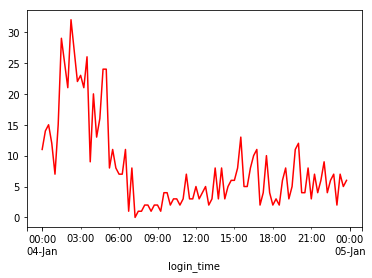

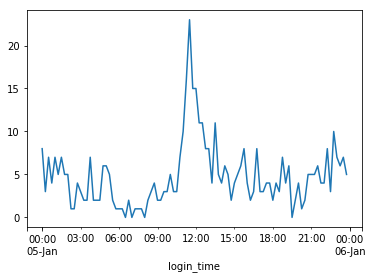

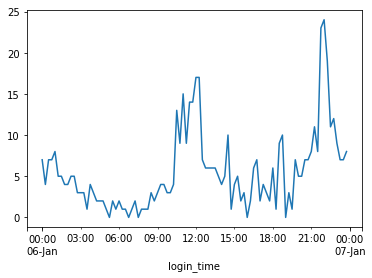

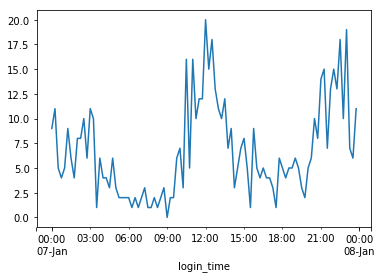

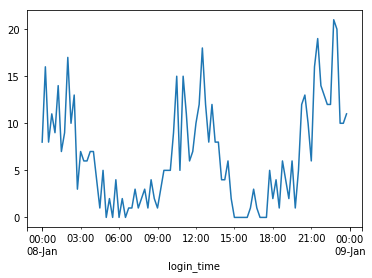

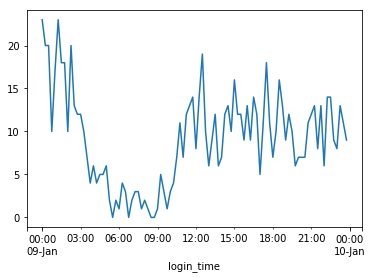

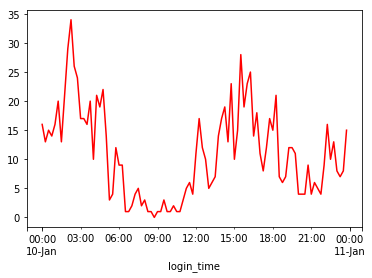

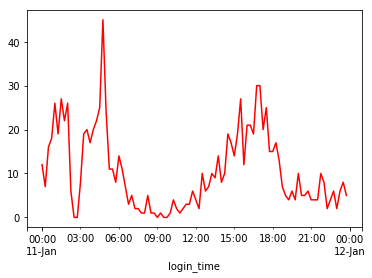

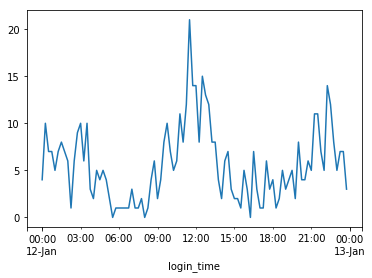

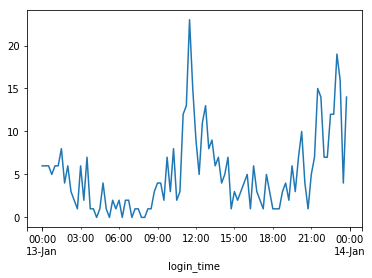

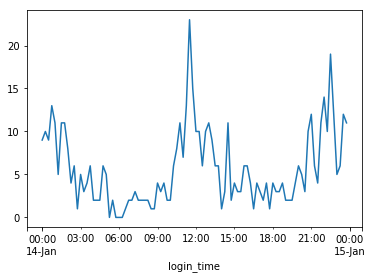

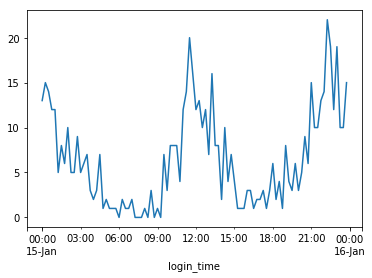

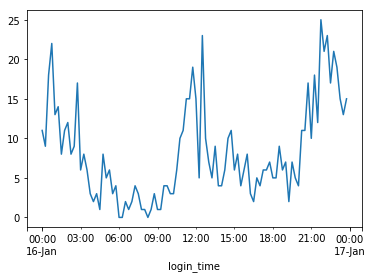

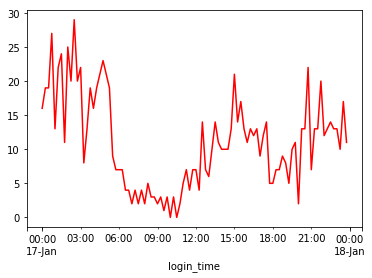

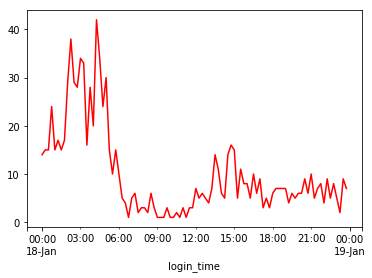

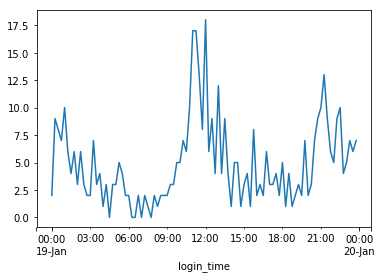

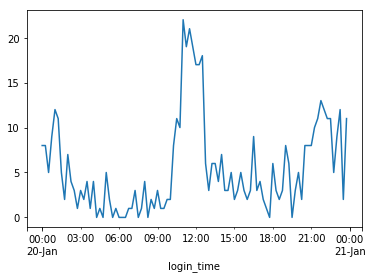

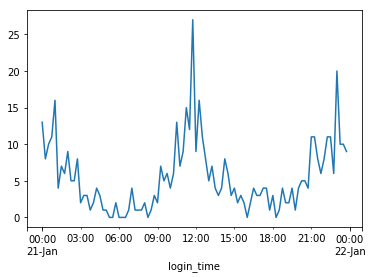

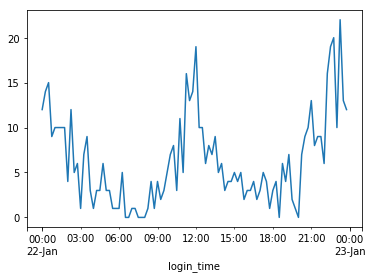

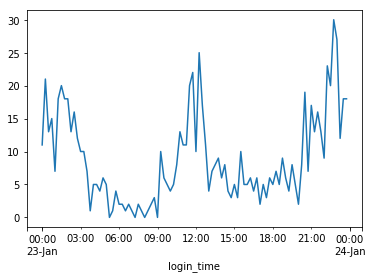

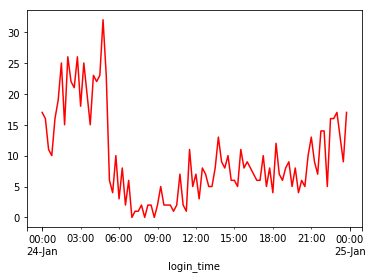

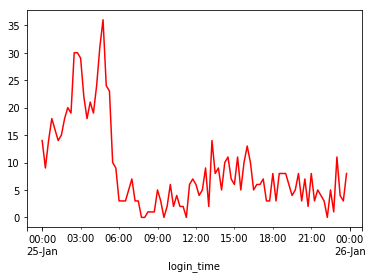

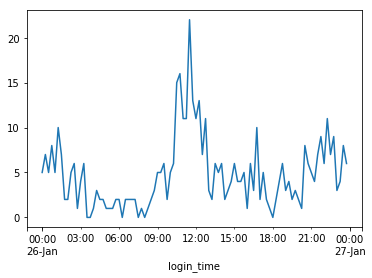

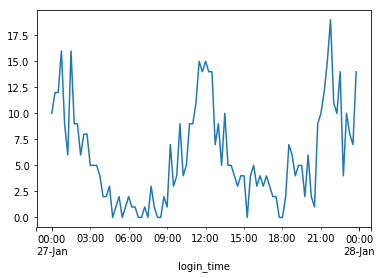

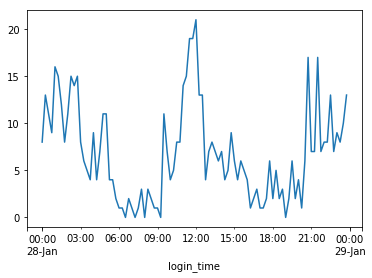

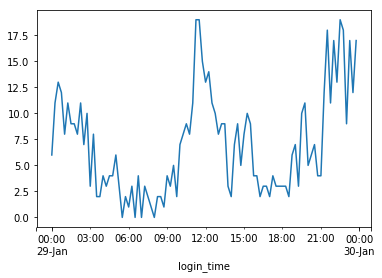

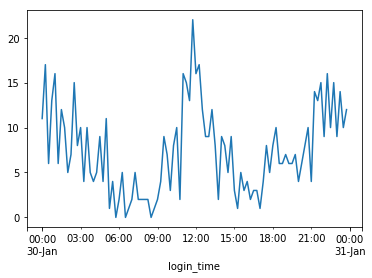

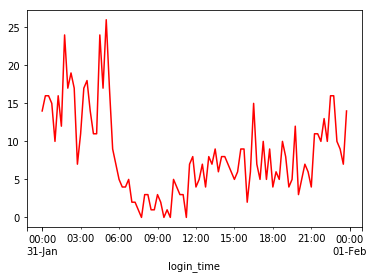

In [45]:
for i in range(2,32):
    #extract daily timestamps one by one
    day = '1970-01-{}'.format(i)
    date = fifteen_min_data.loc[day:day]
    
    #If the current day is a weekend [Saturday or Sunday] color it red
    if i in [3,4,10,11,17,18,24,25,31]:
        date.plot(color='r')
        plt.show()
    #Plot weekdays as blue
    else:
        date.plot()
        plt.show()
    

### For January, there appears to be a weekday trend (Monday-Friday) of high login activity around noon followed by a reduction during midday. The activity then picks up again towards the evening and caps out late in the night with a steady decline into the early morning. The activity stays down until noon time again.  On the weekend (Saturday & Sunday) the activity is the highest at the turn of midnight and trends down throughout the day. It slowly starts to creep back up during the late afternoon and evening, but not to the heights seen during the weekend. Now let's aggregate all the data and see if this trend continues while taking in account February, March, and April

In [46]:
#Create a dataframe of the time series
day_data = pd.DataFrame(fifteen_min_data, columns =['count'])

# Create a column converting the timestamp to it's corresponding day of the week 
# 0 = Monday | 1 = Tuesday | 2 = Wednesday | 3 = Thursday | 4 = Friday | 5 = Saturday | 6 = Sunday
day_data['day_of_week'] = fifteen_min_data.index.dayofweek
day_data.head(10)

,count,day_of_week
login_time,,
1970-01-01 20:00:00,2,3
1970-01-01 20:15:00,6,3
1970-01-01 20:30:00,9,3
1970-01-01 20:45:00,7,3
1970-01-01 21:00:00,1,3
1970-01-01 21:15:00,4,3
1970-01-01 21:30:00,0,3
1970-01-01 21:45:00,4,3
1970-01-01 22:00:00,9,3


### Creat a function that accepts the day_data dataframe and a "day of the week" of interest and  aggregates all login activites then plots the aggregated data for all 4 months in 15 minute samples

In [47]:
def plot_day(df, day, color = None):
    week = {'monday':0,'tuesday':1,'wednesday':2,'thursday':3,'friday':4,'saturday':5,'sunday':6}
    map_day = week[day]
    
    filtered_day = df[df.day_of_week == map_day]
    times = filtered_day.index
    filtered_day = filtered_day.groupby([times.hour, times.minute]).sum()

    
    filtered_day['count'].plot(color = color)
    plt.xlabel('Time of Day')
    plt.ylabel('Login Count')
    plt.title(day.title())
    plt.xticks([])

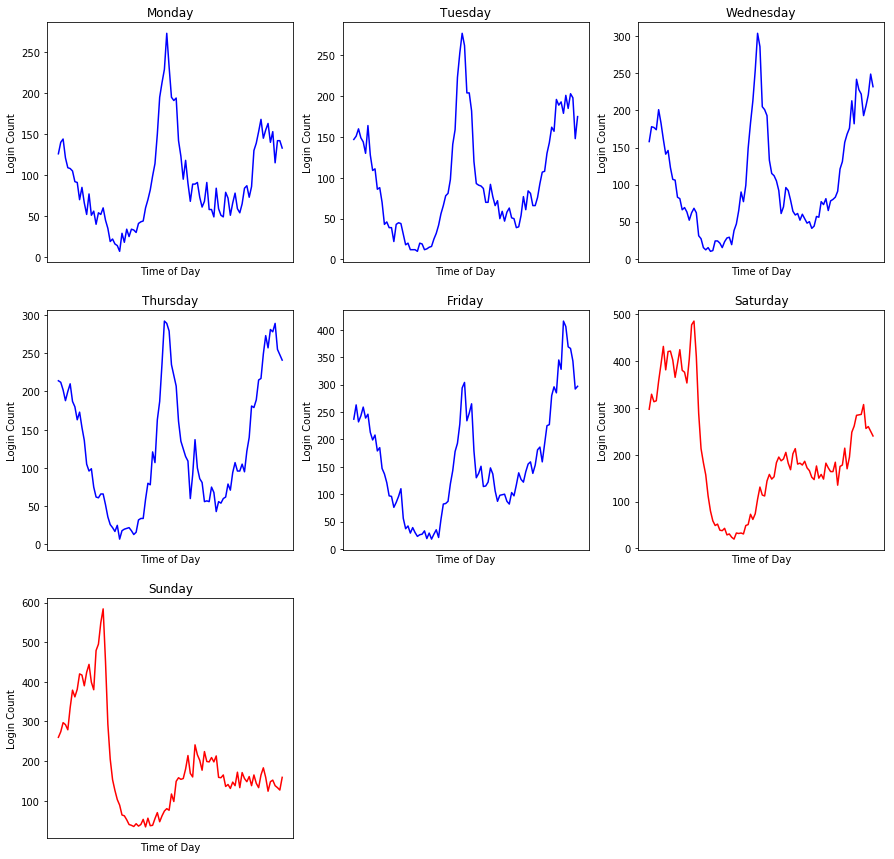

In [48]:
plt.subplots(nrows=3,ncols=3, figsize = (15,15))
ax1 = plt.subplot(3,3,1)
plot_day(day_data, 'monday', color = 'blue')

ax2 = plt.subplot(3,3,2)
plot_day(day_data, 'tuesday', color = 'blue')

ax3 = plt.subplot(3,3,3)
plot_day(day_data, 'wednesday', color = 'blue')

ax4 = plt.subplot(3,3,4)
plot_day(day_data, 'thursday', color = 'blue')

ax5 = plt.subplot(3,3,5)
plot_day(day_data, 'friday', color = 'blue')

ax6 = plt.subplot(3,3,6)
plot_day(day_data, 'saturday', color = 'red')

ax7 = plt.subplot(3,3,7)
plot_day(day_data, 'sunday', color = 'red')

ax8 = plt.subplot(3,3,8)
ax8.spines['right'].set_visible(False)
ax8.spines['top'].set_visible(False)
ax8.spines['left'].set_visible(False)
ax8.spines['bottom'].set_visible(False)
ax8.get_xaxis().set_ticks([])
ax8.get_yaxis().set_ticks([])

ax9 = plt.subplot(3,3,9)
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
ax9.spines['left'].set_visible(False)
ax9.spines['bottom'].set_visible(False)
ax9.get_xaxis().set_ticks([])
ax9.get_yaxis().set_ticks([])

plt.show()


# CONCLUSION

After aggregating the timestamp data for all 4 months, the trend seen in January is confirmed. The highest activity is seen midday and late night into the extremely early morning. The lowest activity is in the morning and afternoon time. This is true for the weekdays. During the weekend however, login activity is the highest in the very early hours and drops off tremendously by midday. It then slowly creeps back up throughout the rest of the day

 # PART 2

The   neighboring   cities   of   Gotham   and   Metropolis   have   complementary   circadian   rhythms:   on 
weekdays,   Ultimate   Gotham   is   most   active   at   night,   and   Ultimate   Metropolis   is   most   active 
during   the   day.   On   weekends,   there   is   reasonable   activity   in   both   cities. 
 
However,   a   toll   bridge,   with   a   two ­way   toll,   between   the   two   cities   causes   driver   partners   to   tend 
to   be   exclusive   to   each   city.   The   Ultimate   managers   of   city   operations   for   the   two   cities   have 
proposed   an   experiment   to   encourage   driver   partners   to   be   available   in   both   cities,   by 
reimbursing   all   toll   costs. 
1. What   would   you   choose   as   the   key   measure   of   success   of   this   experiment   in 
encouraging   driver   partners   to   serve   both   cities,   and   why   would   you   choose   this   metric? 
2. Describe   a   practical   experiment   you   would   design   to   compare   the   effectiveness   of   the 
proposed   change   in   relation   to   the   key   measure   of   success.   Please   provide   details   on:  
a. how   you   will   implement   the   experiment 
b. what   statistical   test(s)   you   will   conduct   to   verify   the   significance   of   the 
observation 
c. how   you   would   interpret   the   results   and   provide   recommendations   to   the   city 
operations   team   along   with   any   caveats. 

### Responses

1.)

If Ultimate drivers are tracked by the pickup and dropoff locations for customers, then their travel back and forth between the cities can also be tracked. Since drivers are exclusvie to their respective cities, then the accumulation of their pickup and dropoff statistics will show which city each driver favors before the testing starts. Therefore an initial aggregation will need to be done on current drivers to seperate them into one of two groups:
* Group A: Ultimate Drivers exclusive to Ultimate Gotham
* Groub B: Ultimage Drivers exclusive to Ultimate Metropolis

The key measure of success when then be whether or not there is an increase of Group A's pickup and/or drop off rate in Metropolis and an increase in Group B's pickup and/or drop off rate in Gotham

2.)

### * A/B Testing *
>*A*

Depending on the timeline restrictions, a baseline would  need to be established. For a respectable length of time, data would be collected on each driver for both cities. This baseline is needed to deterine how often these drivers venture over to the other city. By keeping track of such a thing, we can then use this information to detect an anomaly in their normal behavior (increased service in the other city) versus a random event (every so often a driver provides service in the other city, but they are still exclusive to their respecitive city).

>B

After the baseline is established, then the proposed changes are put into effect for a respectable lenght of time. Again, data would be collected and then compared to the baseline to determine if an increase of service is seen from drivers of the opposing city.

>A

Finally, to ensure the statistical signifigance of the results, after the time for B has expired, the changes will revert back to their original state. After a designated amount of time has passed, a time series analysis will be performed to determine if there was an increase of service among the cities after the changes took effect, and if the results returned to the baseline characteristics after the changes were reverted.




Using a single driver for simplicity, if that particular driver is exclusive to Gotham - After the changes take effect and they are successful, then we should expect to see an increase in that driver's services provided in Metropolis. Then once the changes are reverted, we would expect to see their normal habits return. That is being exclusive to only Gotham. This logic can be applied on the whole population. 

Caveats to this would be duration of test time. Too short, then a reasonable baseline can't be established. Too long then we risk the possiblity of an unstable data set. Drivers could come and go so much that drivers in the baseline might not be driving during the proposed changes. And on the other side, the majority of drivers during the proposed changes timeline could be drivers who weren't present during the establishment of the baseline.